In [1]:
# %% import relevant packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import numba as nb
import sippy
import scipy.io as sio
import scipy.linalg as sla
#import matlab.engine
# import util
#engMAT = matlab.engine.start_matlab()
sns.set()

# Load data

In [2]:
df_raw = pd.read_hdf('../Data/timeseries_complete.hdf5',key='KAAPO_hour_15_16_17_18_19_complete')
df_raw = df_raw[(df_raw.index < "2017-03-26") & (df_raw.index > "2015-07-14")]

df_lab = pd.read_hdf('../Data/Laboratory.hdf5',key='Laboratory').interpolate()
df_lab = df_lab[(df_lab.index < "2017-03-26") & (df_lab.index > "2015-07-14")]

In [3]:
temperature_columns = np.array(
    [['TI8585','TI8553','TI8554','TI8555','TI8556','TI8557','TI8558','TI8559', 'TIZ8578A'],
     ['TI8585','TI8560','TI8561','TI8562','TI8563','TI8564','TI8565','TI8566', 'TIZ8578A'],
     ['TI8585','TI8567','TI8568','TI8569','TI8570','TI8571','TI8572','TI8573', 'TIZ8578A']],dtype=object)
tc_heights =np.array([[7600,6550,5500,4450,3400,2350,1300],
             [7250,6250,5150,4100,3050,2000,950],
             [6900,5850,4800,3750,2700,1650,600]])

In [4]:
# should be listed in the correct order
selected_cols = temperature_columns[2,:]#['TI8585', 'TI8567', 'TI8568', 'TI8569', 'TI8570', 'TI8571', 'TI8572', 'TI8573', 'TIZ8578A']
df_t = df_raw[selected_cols]
df_t = df_t.interpolate(method='time')
df_t = df_t.resample('D').median()
df_t.head()

,TI8585,TI8567,TI8568,TI8569,TI8570,TI8571,TI8572,TI8573,TIZ8578A
date,,,,,,,,,
2015-07-14,204.4250,209.0750,209.7280,210.2930,210.4700,211.5630,210.4980,210.994,211.1000
2015-07-15,194.7055,198.9665,199.9300,200.7380,200.9710,201.9375,200.8945,201.417,201.5500
2015-07-16,204.6715,209.2355,209.9605,210.6150,210.7880,211.8160,210.7940,211.334,211.5030
2015-07-17,202.1135,206.8915,207.5780,208.4285,208.9190,209.8510,208.8655,209.444,209.5435
2015-07-18,200.3230,205.0775,205.9420,206.4265,206.8615,207.7535,206.7335,207.387,207.4560


In [5]:
def get_dz(tc_heights,col):
    dz = np.array([tc_heights[col,i]-tc_heights[col,i+1] for i in range(tc_heights.shape[1]-1)])/1000
    dz = np.concatenate(([1],dz,[1]))
    return dz

In [6]:
def get_delta_df(df_t, selected_cols,dz):
#     dz = [ 1., 6.9-5.85, 5.85-4.8, 4.8-3.75, 3.75-2.7, 2.7-1.65, 1.65-0.6, 1.]
    n_levels = len(dz)
    data = {f"dT{i}" : (df_t[selected_cols[i+1]] - df_t[selected_cols[i]])/dz[i] for i in range(n_levels)}
    return pd.DataFrame(data).clip(lower=0., upper=None)#clip zero by default

# dz2 = [ 1., 6.9-5.85, 5.85-4.8, 4.8-3.75, 3.75-2.7, 2.7-1.65, 1.65-0.6, 1.]
#we could ignore dz
dz  = get_dz(tc_heights,2)
df_dt = get_delta_df(df_t, selected_cols,dz)
# df_dt = df_dt
df = pd.concat([df_dt, df_lab], axis=1)
# df = df.clip(lower=0., upper=None)
# df_weekly = df.resample("W").first()#.dropna()
# df_weekly = df_weekly.clip(lower=0., upper=None)

/home/emzirm1/.conda/envs/CUPYrc/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


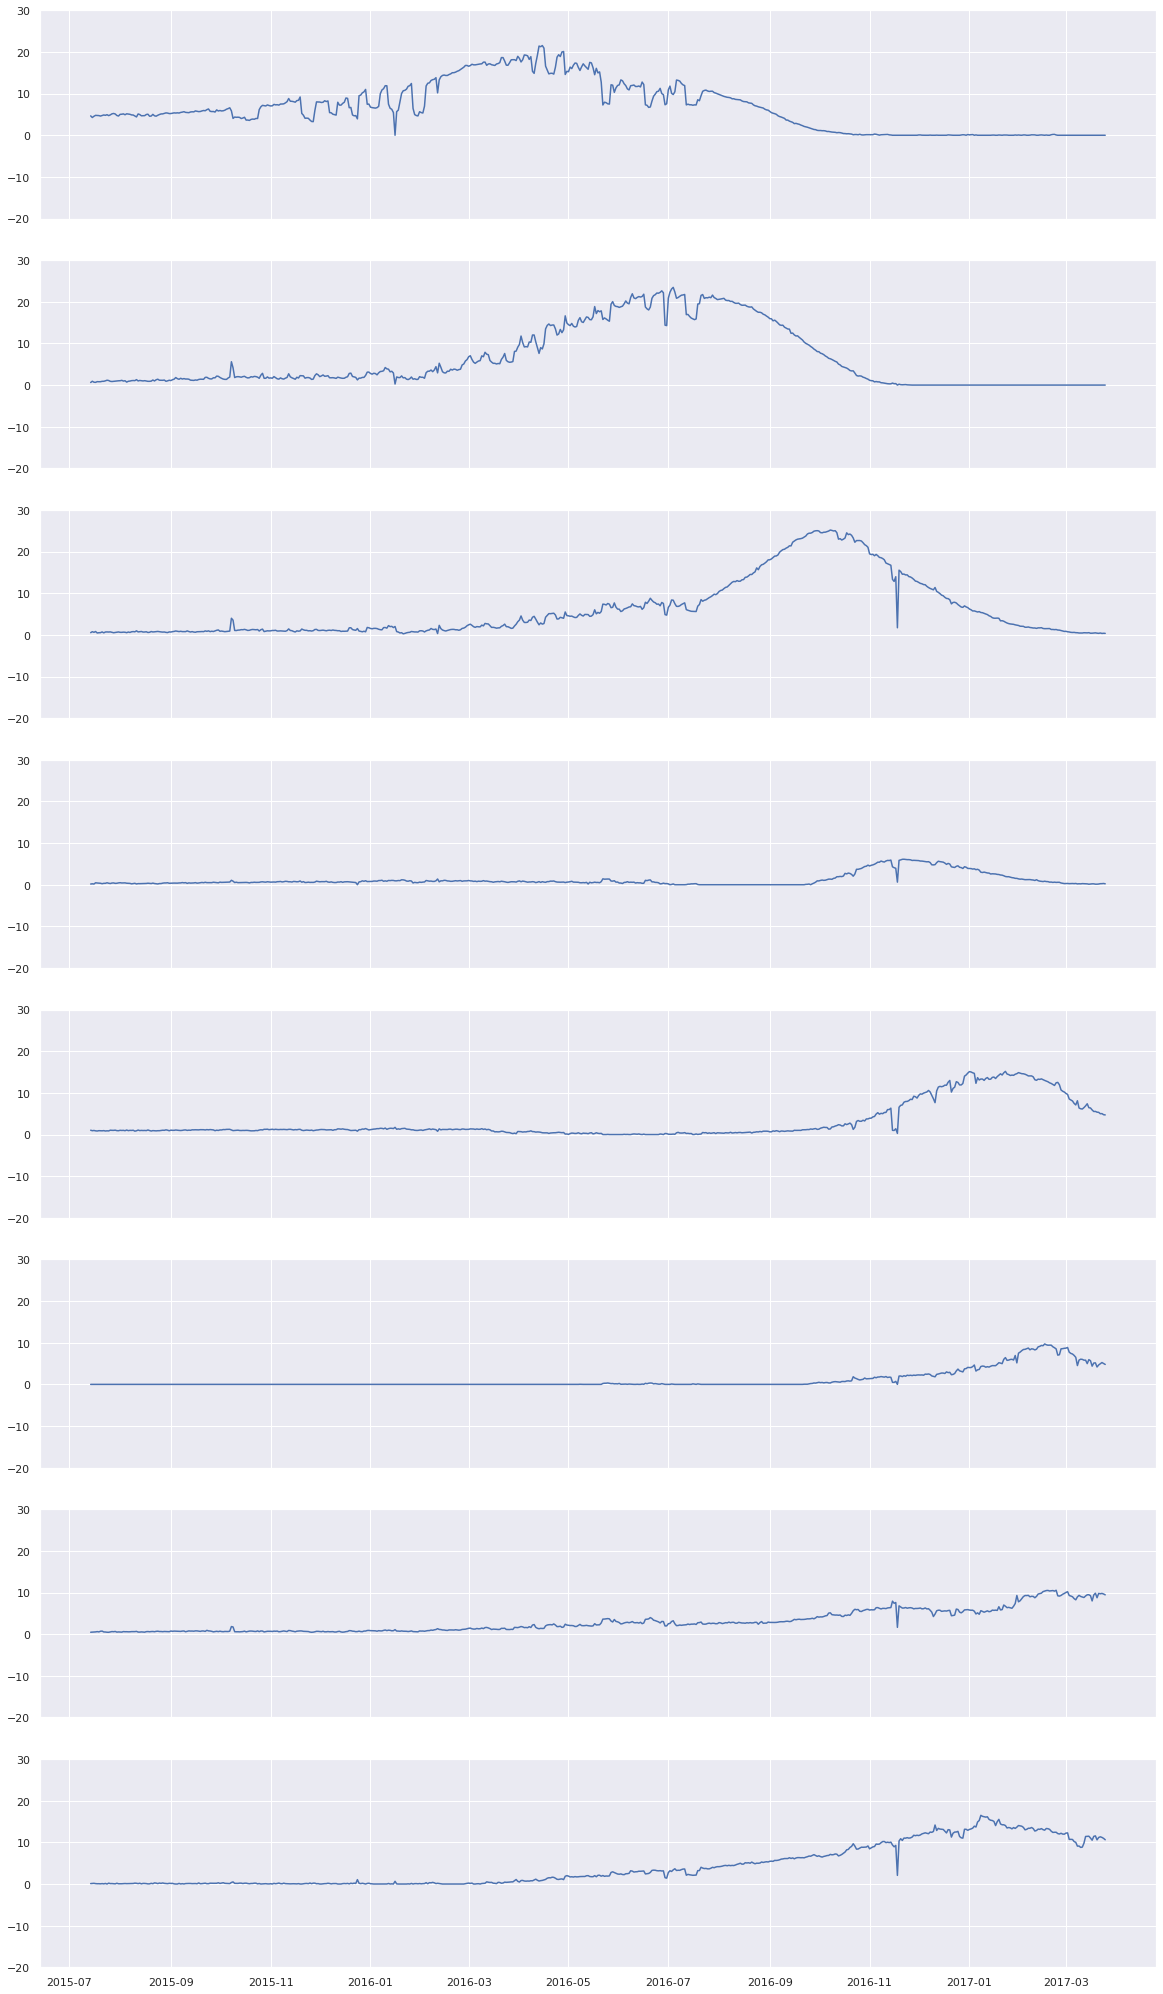

In [7]:
fig, axs = plt.subplots(len(selected_cols)-1, figsize=(20, len(selected_cols)*4), sharex=True)
for i, ax in enumerate(axs):
    ax.plot(df_dt.index, df_dt.values[:, i])
    #ax.set_title(columns[i])
    ax.set_ylim([-20, 30])  
    ax.grid(True)

# Selecting input for system identification

The output set is the $\Delta T$ from the last column, and the input is the sulfur feed, and Aromatic weight percentage from lab data.

In [8]:
y = df[['dT0','dT1','dT2','dT3','dT4','dT5','dT6','dT7' ]].values #the thrid temperature column
u = df[['sulphur feed max','AROM-LC wt-%']].fillna(0).values

# Execute system identification
In this case, we will use `SIPPY` package, and we choose `CVA` method, and the Akaike information criterion to evaluate the models. Horizon of the system identification is set to 30.


In [9]:
horizon = 30
sys_id = sippy.system_identification(y.T,u.T,'N4SID'
                                    #  ,centering='InitVal'
                                     ,SS_p=horizon,SS_f=horizon
                                     ,SS_A_stability=True
                                     ,IC='AIC',SS_orders=[7])

The suggested order is: n= 7


# Check idenfitication result

We will use the first temperature column for validation data

In [10]:
df_dtValidation = get_delta_df(df_t, selected_cols,get_dz(tc_heights,1))
yVal = df_dtValidation.values ##the first temperature column
xid, yid = sippy.functionsetSIM.SS_lsim_predictor_form(sys_id.A_K, sys_id.B_K,sys_id.C, sys_id.D,sys_id.K,yVal.T, u.T, sys_id.x0)

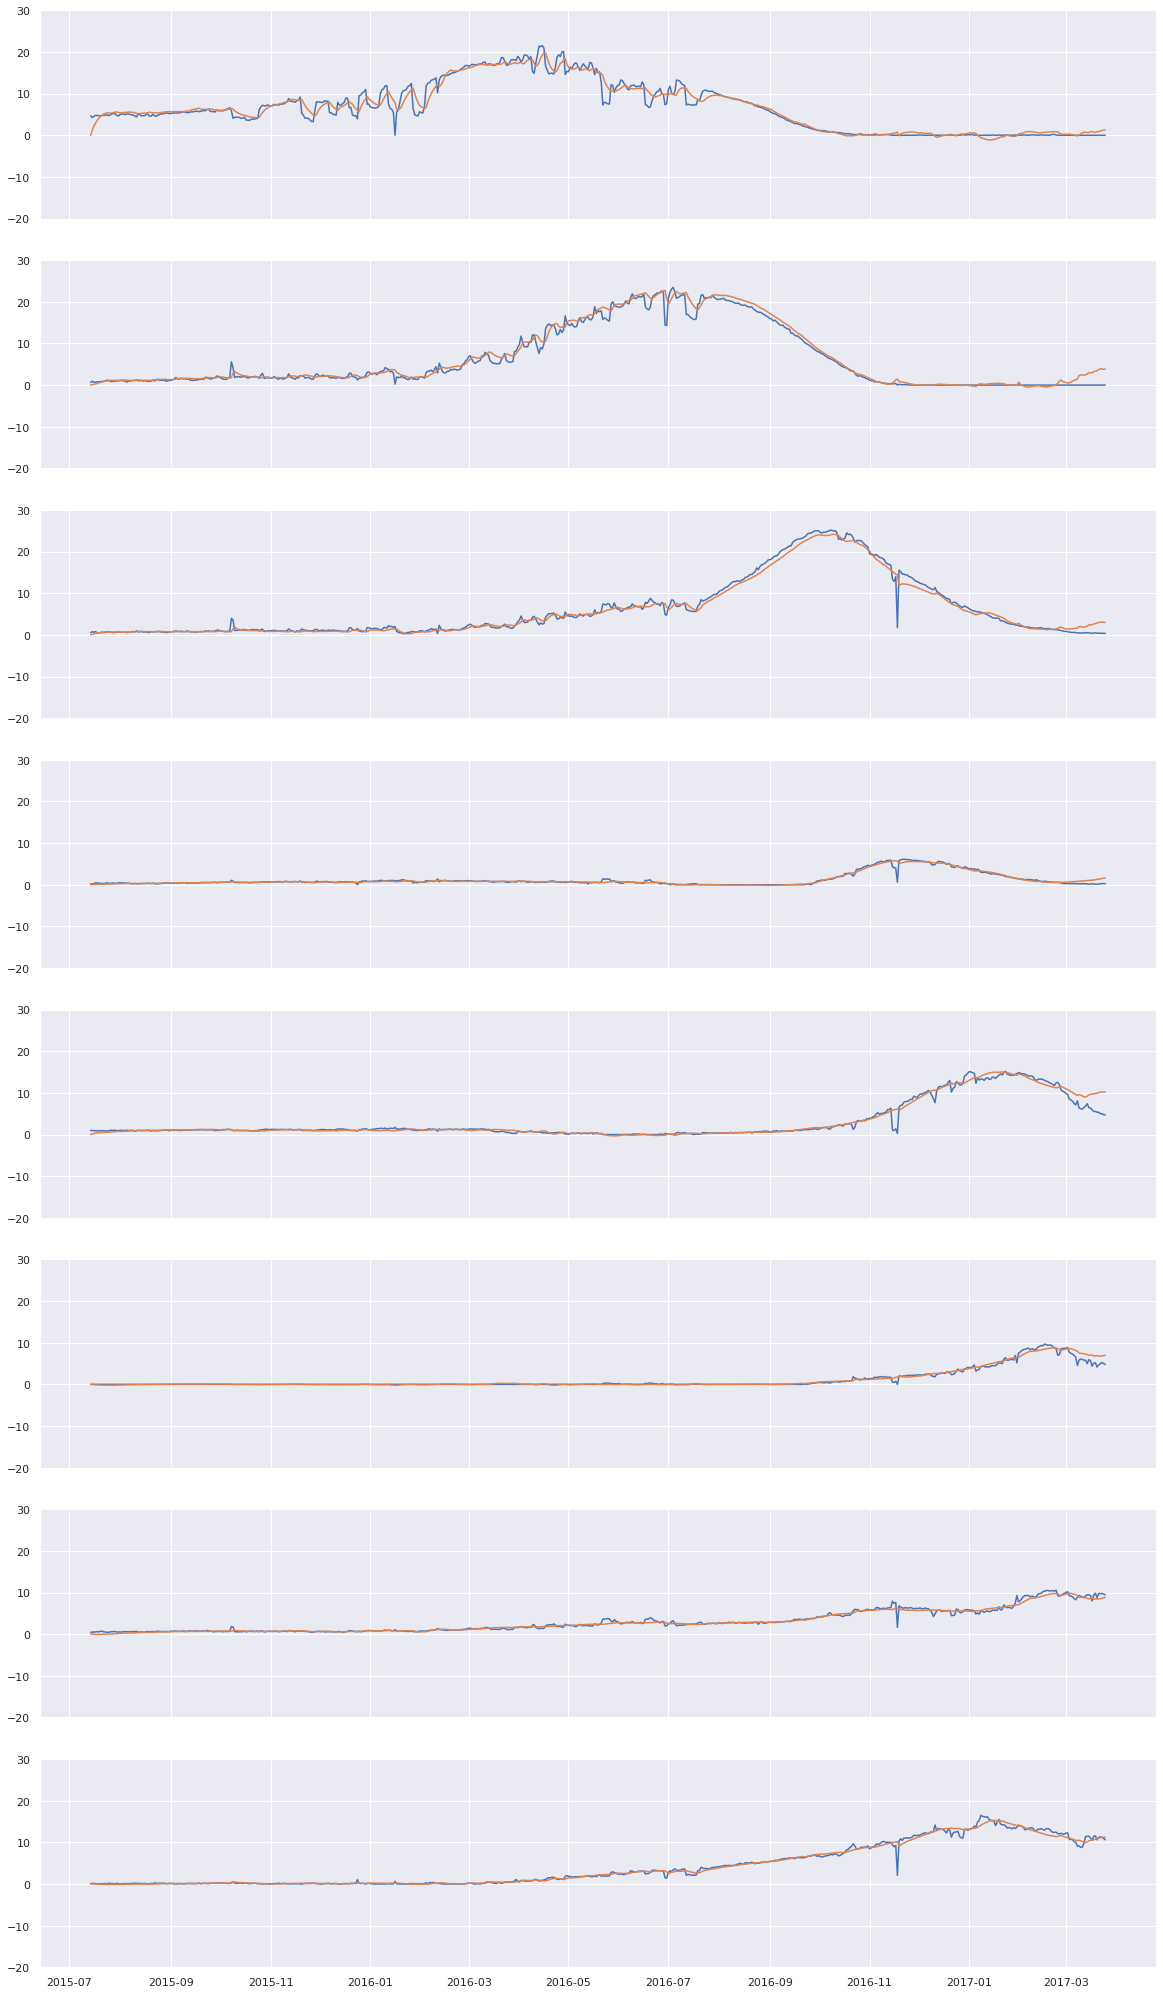

In [11]:
fig, axs = plt.subplots(len(selected_cols)-1, figsize=(20, len(selected_cols)*4), sharex=True)
for i, ax in enumerate(axs):
    ax.plot(df.index, df.values[:, i])
    ax.plot(df.index, yid[i,:])
    #ax.set_title(columns[i])
    ax.set_ylim([-20, 30])  
    ax.grid(True)

# Get insight into the dynamics
To get insight of what is really the "catalyst activity", we could transform the matrices we get from system identification procedure to lower/upper triangular matrix. This is done using Schur transformation. However, the "catalyst activity" perhaps not really the state $x$ it self, but rather some constant minus $x$ because system identification algorithm assume that initially system at zero, which is the opposite of the catalyst state which initially at full state.
The Schur transformation will gives a "complex" state value $x$. In this case we take the absolute value of it.
This resulted in the estimate of the catalyst activity that resembles decline at different lavels, but the oscillation is inevitable due to the nature of the linear dynamics resulted from system identification.
This is what to be corrected using Gaussian Process system identification.

In [12]:
#Transform to Triangular form using Schur transformation
Asch,Tsch = sla.schur(sys_id.A,output='complex')
T_t = Tsch.conj().T
Bsch = T_t@sys_id.B
Ksch = T_t@sys_id.K
Csch = sys_id.C@Tsch
Dsch = sys_id.D

In [13]:
xidsch = np.zeros((Asch.shape[0],yVal.shape[0]),dtype=np.complex128)
P = np.zeros((yVal.shape[0],Asch.shape[0],Asch.shape[0]),dtype=np.complex128)
I = np.eye(Asch.shape[0])
P[0,:,:] = I
Q = I*1e-3
# xid[:,0] = np.ones(Asch.shape[0])
yid = np.zeros_like(yVal).T
u_t = u.T
yVal_t = yVal.T
xidsch = Tsch@xid
xidsch = xidsch[:,:-1]
for i in range(yVal.shape[0]-1):
    P[i+1,:,:] = (I-Ksch@Csch)@(Asch@P[i,:,:]@Asch.T+Q)
    

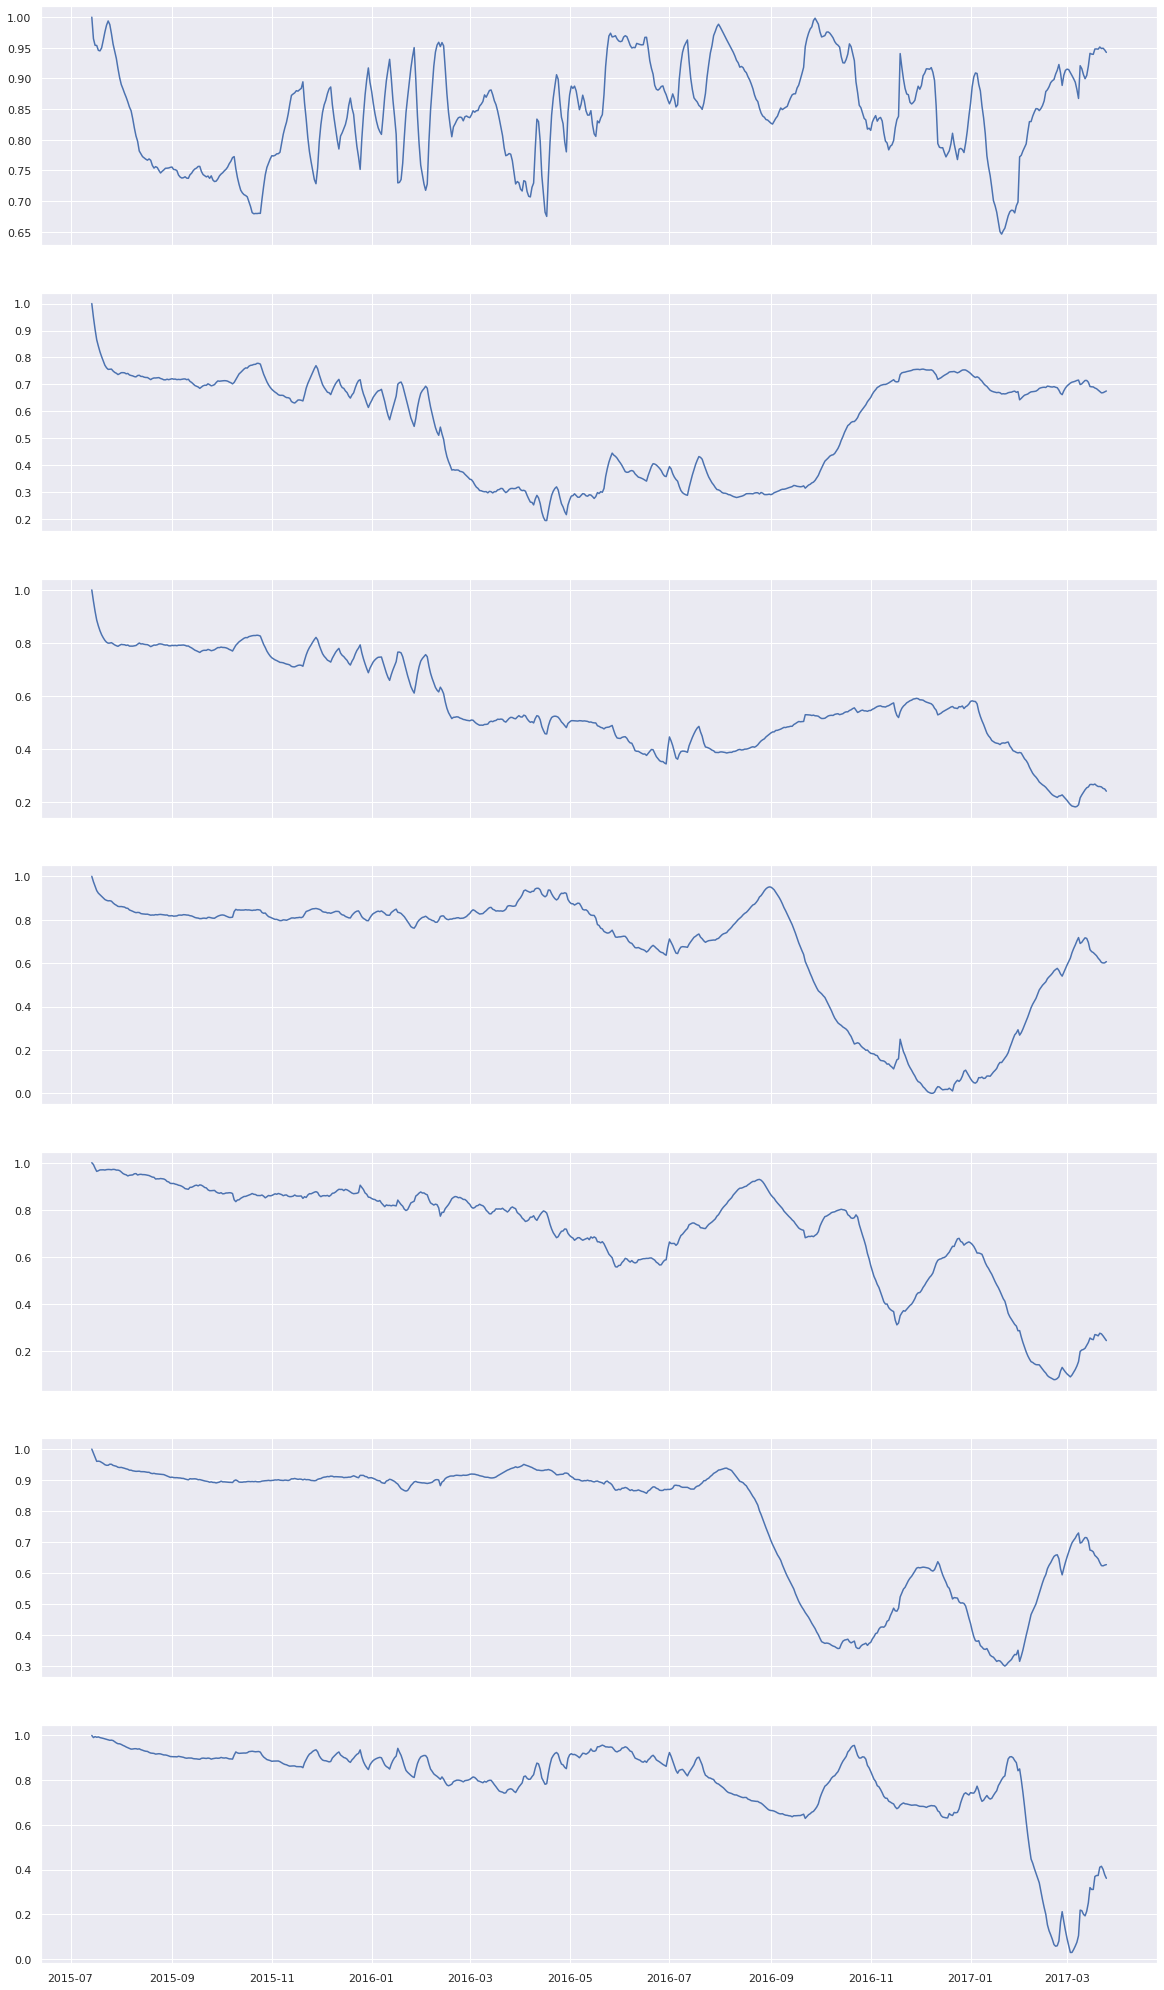

In [14]:
fig, axs = plt.subplots(Asch.shape[0], figsize=(20, len(selected_cols)*4), sharex=True)
max_x = np.max(np.absolute(xidsch))
for i, ax in enumerate(axs):
#     ax.plot(df.index, df.values[:, i])
    xabs = np.absolute(xidsch[xidsch.shape[0]-(i+1),:])
    xabs = xabs/max_x #scaled to [0,1]
    ax.plot(df.index, 1-xabs)
#     ax.set_title('Catalyst activity')
#     ax.set_ylim([-20, 30])  
    ax.grid(True)

In [15]:
sio.savemat('RawData.mat',
{'y':df_raw[temperature_columns.flatten()].values,
'u':u,
'temperature_columns':temperature_columns,
}
)

In [18]:
sio.savemat('../ForIdentification.mat',
{'y':y,
'u':u,
 'yVal':yVal,
'temperature_columns':temperature_columns,
}
)